In [11]:
import torch
import numpy as np
import torchvision
from torchvision import models
from torchsummary import summary
import torchvision.transforms as transforms

In [12]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])

In [13]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [18]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=32)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [52]:
import torch.nn.functional as F
num_classes = 10
one_hot_labels = F.one_hot(labels, num_classes=num_classes)

In [53]:
one_hot_labels[0]

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [54]:
images[0].shape

torch.Size([3, 32, 32])

In [55]:
image = np.transpose(images[0], (1, 2, 0))
image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
image = np.clip(image, 0, 1)

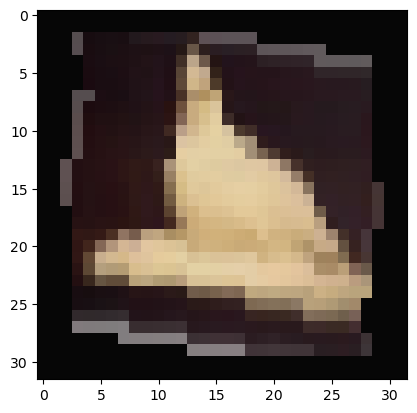

In [56]:
import matplotlib.pyplot as plt

plt.imshow(image)

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [58]:
import torch.nn as nn
import torch.optim as optim

In [59]:
images.shape

torch.Size([32, 3, 32, 32])

In [117]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # Feature extraction layers
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 1st Convolutional layer
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 2nd Convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),  # Max Pooling
            nn.Dropout(0.25)
        )
        self.features2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 3rd Convolutional layer
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 4th Convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),  # Max Pooling
            nn.Dropout(0.25)
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the tensor
            nn.Linear(64 * 8 * 8, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer
        )
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.classifier(x)
        return x

model = ConvNet(num_classes)
model = model.to(device)

In [118]:
model

ConvNet(
  (features1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (features2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [119]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [120]:
dataiter = iter(trainloader)
inputs, labels = next(dataiter)
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)

In [121]:
outputs[0]

tensor([ 0.0069, -0.0174, -0.0532, -0.0436,  0.0002,  0.0027,  0.0265,  0.0547,
        -0.0025, -0.0536], device='cuda:0', grad_fn=<SelectBackward0>)

In [122]:
labels

tensor([6, 9, 4, 5, 6, 6, 2, 0, 6, 8, 3, 8, 9, 4, 0, 2, 3, 2, 9, 6, 0, 7, 8, 5,
        9, 7, 6, 8, 4, 8, 2, 1], device='cuda:0')

In [123]:
loss = criterion(outputs, labels)
loss

tensor(2.3066, device='cuda:0', grad_fn=<NllLossBackward0>)

In [128]:
import copy

def train(model, criterion, optimizer, num_epochs, dataloader_train, dataloader_val=None):
    history = {
        'loss':[],
        'acc': [],
        'val_loss' : [],
        'val_acc': [],
        'best_train_acc' : (0, 0)
    }
    best_acc = 0.0
    best_model_weight = copy.deepcopy(model.state_dict())
    train_dataset_size = len(dataloader_train.dataset)
    test_dataset_size = len(dataloader_val.dataset)
    
    for e in range(num_epochs):
        print(f'\033[1;35mEpoch:{e}\033[0m')
        model.train() # change model to training mode
        each_epoch_loss = 0.0
        each_epoch_acc = 0.0
        each_epoch_val_loss = 0.0
        each_epoch_val_acc = 0.0
        
        for inputs, labels in dataloader_train:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backpropagation and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #values, indexes
            _, pred = torch.max(outputs, 1) # choose the first biggest value
            
            # Store result
            each_epoch_loss += loss.item()
            each_epoch_acc += (pred == labels).sum().item()
            
        # Update history result
        each_epoch_loss /= train_dataset_size
        each_epoch_acc /= train_dataset_size
        each_epoch_acc *= 100
        
        history['loss'].append(each_epoch_loss)
        history['acc'].append(each_epoch_acc)
        
        print(f'\033[1;34mTrainning: Epoch:{e} Loss:{each_epoch_loss:.2f} Accuracy:{each_epoch_acc:.2f}\033[0m')
    
        # Store best result
        if each_epoch_acc > best_acc:
            best_acc = each_epoch_acc
            best_model_weight = copy.deepcopy(model.state_dict())
            history['best_train_acc'] = (e, best_acc)
            
        if dataloader_val:
            model.eval() # change model to evaluate mode
            
            with torch.no_grad():
                for inputs, labels in dataloader_val:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Evaluate
                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)
                    
                    # values, indexes
                    _, pred = torch.max(outputs, 1)
                    
                    # Store result
                    each_epoch_val_loss += val_loss.item()
                    each_epoch_val_acc += (pred == labels).sum().item()
                    
                each_epoch_val_loss /= test_dataset_size
                each_epoch_val_acc /= test_dataset_size
                each_epoch_val_acc *= 100
                
            history['val_loss'].append(each_epoch_val_loss)
            history['val_acc'].append(each_epoch_val_acc)
            
            print(f'\033[1;34mTesting: Epoch:{e} Loss:{each_epoch_val_loss:.2f} Accuracy:{each_epoch_val_acc:.2f}\033[0m')
            
    print(f"Best Result in \033[1;35mEpoch:{history['best_train_acc'][0]}\033[0m \033[1;33mAccuracy:{history['best_train_acc'][1]:.2f}\033[0m")
    model.load_state_dict(best_model_weight) 
    
    return model, history

In [129]:
num_epochs = 30
model, history = train(model, criterion, optim, num_epochs, trainloader, testloader)

Epoch:0
Trainning: Epoch:0 Loss:0.05 Accuracy:38.86
Testing: Epoch:0 Loss:0.05 Accuracy:46.19
Epoch:1
Trainning: Epoch:1 Loss:0.05 Accuracy:43.39
Testing: Epoch:1 Loss:0.04 Accuracy:49.62
Epoch:2
Trainning: Epoch:2 Loss:0.05 Accuracy:46.59
Testing: Epoch:2 Loss:0.04 Accuracy:53.12
Epoch:3
Trainning: Epoch:3 Loss:0.04 Accuracy:49.16
Testing: Epoch:3 Loss:0.04 Accuracy:55.80
Epoch:4
Trainning: Epoch:4 Loss:0.04 Accuracy:51.41
Testing: Epoch:4 Loss:0.04 Accuracy:59.24
Epoch:5
Trainning: Epoch:5 Loss:0.04 Accuracy:54.02
Testing: Epoch:5 Loss:0.03 Accuracy:60.97
Epoch:6
Trainning: Epoch:6 Loss:0.04 Accuracy:55.63
Testing: Epoch:6 Loss:0.03 Accuracy:62.32
Epoch:7
Trainning: Epoch:7 Loss:0.04 Accuracy:57.36
Testing: Epoch:7 Loss:0.03 Accuracy:64.60
Epoch:8
Trainning: Epoch:8 Loss:0.04 Accuracy:59.21
Testing: Epoch:8 Loss:0.03 Accuracy:65.67
Epoch:9
Trainning: Epoch:9 Loss:0.04 Accuracy:60.19
Testing: Epoch:9 Loss:0.03 Accuracy:67.35
Epoch:10
Trainning: Epoch:10 Loss:0.03 Accuracy:61.37
Testin

In [130]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history['acc']
    loss = history['loss']
    val_acc = history['val_acc']
    val_loss = history['val_loss']
    
    x = range(len(acc)) # X-axis
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, color='#525ab3', linewidth=2, label='Train acc')
    plt.plot(x, val_acc, color='#914c4c', linewidth=2, label='Val acc')
#     plt.plot(history['best_train_acc'][0], history['best_train_acc'][1], 'bo',label='Best train acc', markersize=7, color='black')
    plt.plot(history['best_train_acc'][0], history['best_train_acc'][1], 'o', label='Best train acc', markersize=7, color='black')

    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, color='#525ab3', linewidth=2, label='Train loss')
    plt.plot(x, val_loss, color='#914c4c', linewidth=2, label='Val loss')
    plt.legend()
    plt.title('Loss')
    
    plt.tight_layout()
    plt.show()

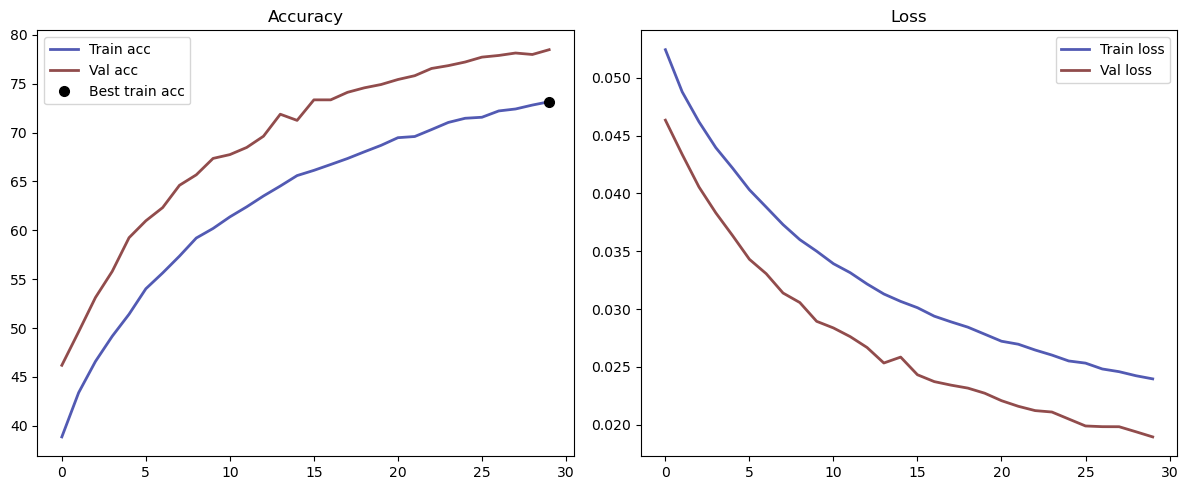

In [131]:
plot_history(history)

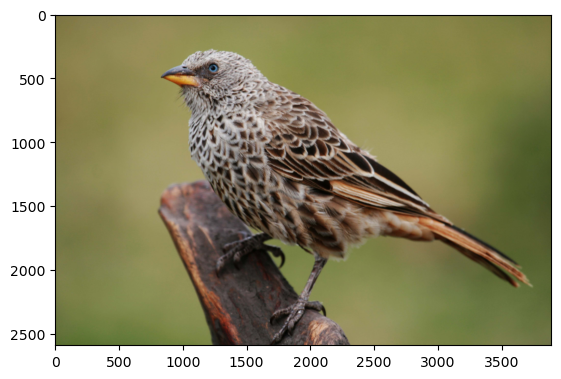

In [154]:
# Test model with an image
image = plt.imread('bird.jpg')
plt.imshow(image)

tensor(4)


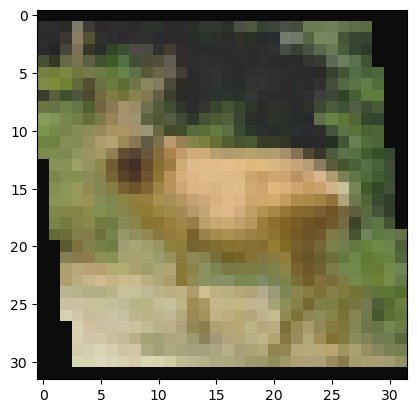

In [152]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images.shape
im = np.transpose(images[0], (1, 2, 0))
im = im/2 + 0.5
print(labels[0])
plt.imshow(im)

In [155]:
image.shape

(2592, 3888, 3)

In [165]:
# Define the transformation with antialias=True
test_image_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32), antialias=True)])

convert_image = test_image_transform(image)

convert_image = convert_image.to(device)

convert_image.shape

torch.Size([3, 32, 32])

In [171]:
model.eval()
testoutput = model(convert_image.unsqueeze(0))
testoutput = torch.nn.functional.softmax(testoutput, dim=1)

In [172]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [173]:
testoutput

tensor([[6.5175e-03, 2.4300e-07, 9.0512e-01, 4.3249e-02, 4.6721e-03, 2.1107e-02,
         1.7573e-02, 2.4500e-04, 1.5136e-03, 6.9220e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [174]:
confidence, pred = torch.max(testoutput, 1)
pred_label = classes[pred]
print(f'Confidence:{confidence.item()} Predict Label:{pred_label} True Label:bird')

Confidence:0.9051159024238586 Predict Label:bird True Label:bird


## Save Model

In [153]:
# Save Model
model_path = 'mynet.pth'
torch.save(model, model_path)